In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append('/home/enric/.mujoco/mujoco200/bin')

import tensorflow as tf
import tensorflow.keras.layers as KL
import tensorflow.keras.optimizers as KO
import tensorflow.keras as K

# Memory

In [2]:
class Memory:
    """A FIFO experiene replay buffer.
    """
    def __init__(self,obs_dim,act_dim,size):
        self.states = np.zeros([size, obs_dim], dtype=np.float32)
        self.actions = np.zeros([size, act_dim], dtype=np.float32)
        self.rewards = np.zeros(size, dtype=np.float32)
        self.next_states = np.zeros([size, obs_dim], dtype=np.float32)
        self.dones = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
    
    def store(self,state,action,reward,next_state,done):
        self.states[self.ptr] = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)
    
    def get_sample(self, batch_size = 32):
        idxs = np.random.randint(0,self.size,size=batch_size)
        return self.states[idxs],self.actions[idxs],self.rewards[idxs],self.next_states[idxs],self.dones[idxs]


# DDPG Agent

In [5]:
class DDPGAgent:
    """The DDPG Agent object.
    The actor and critic are both created in here. 
    Requires some intel form the env to be creates.
    Public Methods to interact with:
        :store: store an experience pair, aka trajectory, aka SARS'D
        :get_action: get an action from the current actor
        :get_target_action: get an action from the current target actor - ideally the optimal policy
        :train: call a training run of the network. Will select a randsom batch and uptadte the neural nets and perform a soft update of target -actor and -critic
    Params:
        :state_dim: dimension from the observation space of the environment.
        :action_n: number of actions. Here, it is implicitly expected to work in continous environments as DDPG was designed for.
        :act_limit: min and max of the number generates by the network output. Usually 1. 
    """
    def __init__(self,state_dim,action_n,act_limit):
        #env intel
        self.action_n = action_n
        self.state_dim = state_dim
        self.state_n = state_dim[0]
        #constants
        self.ACT_LIMIT = act_limit #requiered for clipping prediciton aciton
        self.GAMMA = 0.99 #discounted reward factor
        self.TAU = 0.005 #soft update factor
        self.BUFFER_SIZE = int(1e6) #total replay buffer size. Should be quite large.
        self.BATCH_SIZE = 100 #training batch size. 
        self.ACT_NOISE_SCALE = 0.1 #the noise is for exploration. simple randomnormal is used here insead of OUNoise like in the orgininal paper an din many examples. OUNoise does not bring much benefit.
        #create networks
        self.actor = self._gen_actor_network() #the local actor wich is trained on.
        self.actor_target = self._gen_actor_network() #the target actor which is slowly updated toward optimum
        self.critic = self._gen_critic_network()
        self.critic_target = self._gen_critic_network()
        #Other vital elements
        self.memory = Memory(self.state_n,self.action_n,self.BUFFER_SIZE)
        #Dummies. These are required due to the model declartion and loss declarion
        #style of keras. In short, for complex losses extra inputs need to be declared
        #but for a model.predict call, they obvisually don't play a role so dummies are passed
        self.dummy_Q_target_prediction_input = np.zeros((self.BATCH_SIZE, 1))
        self.dummy_dones_input = np.zeros((self.BATCH_SIZE, 1))

    
    """-----------------------------ACTOR declarions and methods------------------------------------
    The Actor takes a state and predicts an action
    """
    def _gen_actor_network(self):
        state_input = KL.Input(shape=self.state_dim)
        dense = KL.Dense(400,activation='relu')(state_input)
        dense = KL.Dense(300,activation='relu')(dense)
        out = KL.Dense(self.action_n,activation = 'tanh')(dense)
        model = K.Model(inputs=state_input,outputs=out)
        model.compile(optimizer = 'adam', loss = self._ddpg_actor_loss)
        model.summary()
        return model

    
    def _ddpg_actor_loss(self,y_true,y_pred):
        #y_true is Q_prediction = Q_critic_predicted(s,a_actor_predicted)
        return -K.backend.mean(y_true)

    
    def get_action(self,states,noise=None):
        """Returns an action (=prediction of local actor) given a state.
        Adds a gaussion noise for exploration. 
        params:
            :state: the state batch
            :noise: add noise. If None defaults self.ACT_NOISE_SCALE is used.
                    If 0 ist passed, no noise is added and clipping passed
        """
        if noise is None: noise = self.ACT_NOISE_SCALE
        if len(states.shape) == 1: states = states.reshape(1,-1)
        action = self.actor.predict_on_batch(states)
        if noise != 0:
            action += noise * np.random.randn(self.action_n)
            action = np.clip(action, -self.ACT_LIMIT, self.ACT_LIMIT)
        return action

    
    def get_target_action(self,states):
        return self.actor_target.predict_on_batch(states)
    
    
    def train_actor(self,states,actions):
        #Q_predictions can not be calculated in keras loss function because it depends on the prediction
        #of another model (critic) with the prediction of this model (actions) as a parameter.
        actions_predict = self.get_action(states, noise=0)
        Q_predictions = self.get_Q(states,actions_predict)
        self.actor.train_on_batch(states,Q_predictions)
    

    """-----------------------------CRITIC declarion and methods------------------------------------
    The Critic, in the DDPG case, is the Q(s,a)
    """
    def _gen_critic_network(self):
        #Inputs to network. Most of them are for the loss function, not for the feed forward
        state_input = KL.Input(shape=self.state_dim,name='state_input')
        action_input = KL.Input(shape=(self.action_n,),name='action_input')
        Q_target_prediction_input = KL.Input(shape=(1,),name='Q_target_prediction_input')
        dones_input = KL.Input(shape=(1,),name='dones_input')
        #define network structure
        concat_state_action = KL.concatenate([state_input,action_input])
        dense = KL.Dense(400,activation='relu')(concat_state_action)
        dense = KL.Dense(300,activation='relu')(dense)
        out = KL.Dense(1,activation = 'linear')(dense)
        model = K.Model(inputs=[state_input,action_input,Q_target_prediction_input,dones_input],outputs=out)
        model.compile(optimizer = 'adam', loss = self._ddpg_critic_loss(Q_target_prediction_input,dones_input))
        model.summary()
        return model
    

    def _ddpg_critic_loss(self,Q_target_prediction_input,dones_input):
        def loss(y_true,y_pred):
            #remember: y_true = rewards ; y_pred = Q 
            target_Q = y_true + (self.GAMMA * Q_target_prediction_input * (1 - dones_input))
            mse = K.losses.mse(target_Q,y_pred)
            return mse
        return loss
    

    def train_critic(self,states,next_states,actions,rewards,dones):
        """Train the critic using a trajectory batch from memory.
        This is part of the core algorithm. https://spinningup.openai.com/en/latest/algorithms/ddpg.html
        The loss of the critic requires the predicted Q(s,a) which is the prediction of the critic.
        """
        next_actions = self.get_target_action(next_states)
        Q_target_prediction = self.get_target_Q(next_states,next_actions)
        self.critic.train_on_batch([states,actions,Q_target_prediction,dones],rewards)
    

    def get_Q(self,states,actions):
        return self.critic.predict([states,actions,self.dummy_Q_target_prediction_input,self.dummy_dones_input])
    

    def get_target_Q(self,states,actions):
        return self.critic_target.predict_on_batch([states,actions,self.dummy_Q_target_prediction_input,self.dummy_dones_input])
    

    """-----------------------------AGENT interface and logic------------------------------------
    The Critic, in the DDPG case, is the Q(s,a)
    """

    def _soft_update_actor_and_critic(self):
        """Makes a soft update of the target models with the latest local model weights.
        Uses the factor self.TAU to determine the how soft. Usually, tau is small.
        """
        #Critic soft update:
        weights_critic_local = np.array(self.critic.get_weights())
        weights_critic_target = np.array(self.critic_target.get_weights())
        self.critic.set_weights(self.TAU * weights_critic_local + (1.0-self.TAU)*weights_critic_target)
        #Actor soft update
        weights_actor_local = np.array(self.actor.get_weights())
        weights_actor_target = np.array(self.actor_target.get_weights())
        self.actor_target.set_weights(self.TAU * weights_actor_local + (1.0-self.TAU)*weights_actor_target)


    def store(self,state,action,reward,next_state,done):
        """Stores a trajectory
        Just passes though to memory to keep object structure.
        """
        self.memory.store(state,action,reward,next_state,done)


    def train(self):
        """Trains the networks of the agent (local actor and critic) and soft-updates thier target.
        """
        states,actions,rewards,next_states,dones = self.memory.get_sample(batch_size = self.BATCH_SIZE)
        self.train_critic(states,next_states,actions,rewards,dones)
        self.train_actor(states,actions)
        self._soft_update_actor_and_critic()

# Main

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 400)               1600      
_________________________________________________________________
dense_13 (Dense)             (None, 300)               120300    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 602       
Total params: 122,502
Trainable params: 122,502
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
____________________________________

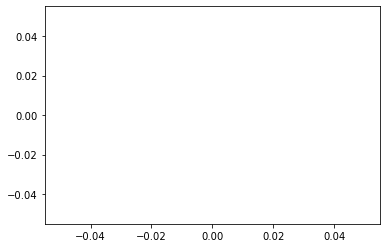

  0%|          | 1/3000000 [00:00<135:29:09,  6.15it/s]

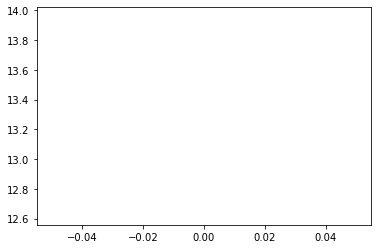

  0%|          | 2/3000000 [00:00<141:42:40,  5.88it/s]

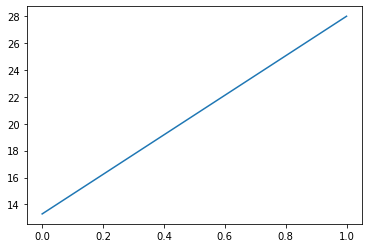

  0%|          | 3/3000000 [00:00<170:00:35,  4.90it/s]

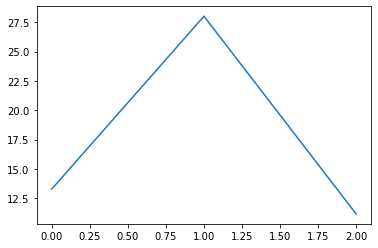

  0%|          | 4/3000000 [00:00<174:16:33,  4.78it/s]

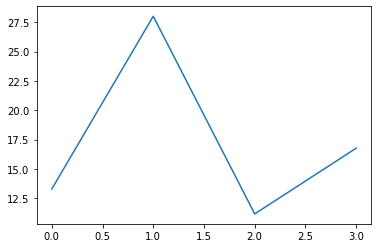

  0%|          | 5/3000000 [00:01<168:52:33,  4.93it/s]

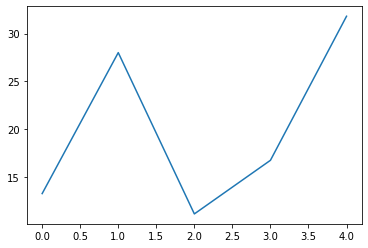

  0%|          | 6/3000000 [00:01<189:00:55,  4.41it/s]

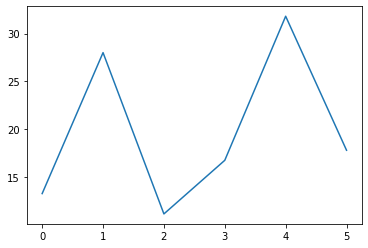

  0%|          | 7/3000000 [00:01<192:09:01,  4.34it/s]

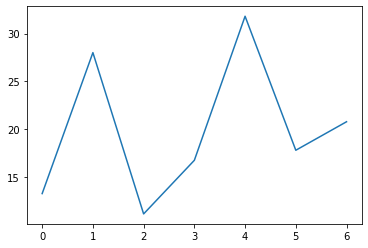

  0%|          | 8/3000000 [00:01<187:36:48,  4.44it/s]

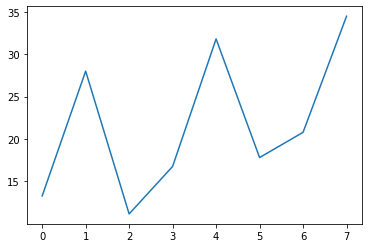

  0%|          | 9/3000000 [00:02<187:55:40,  4.43it/s]

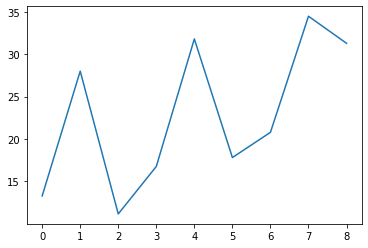

  0%|          | 10/3000000 [00:02<246:44:27,  3.38it/s]

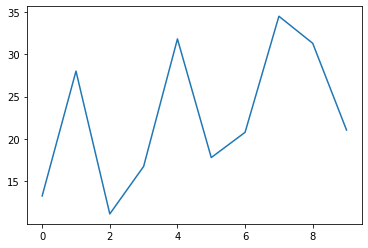

  0%|          | 11/3000000 [00:02<219:20:36,  3.80it/s]

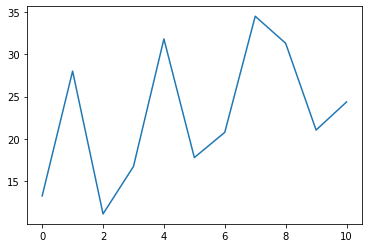

  0%|          | 12/3000000 [00:02<201:23:52,  4.14it/s]

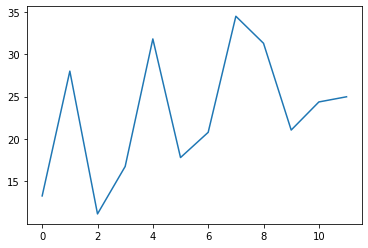

  0%|          | 13/3000000 [00:03<232:29:01,  3.58it/s]

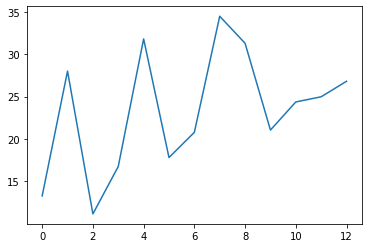

  0%|          | 14/3000000 [00:03<235:48:01,  3.53it/s]

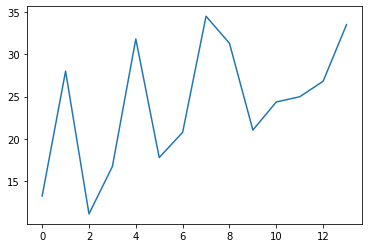

  0%|          | 15/3000000 [00:03<237:06:34,  3.51it/s]

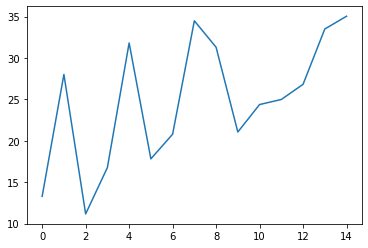

  0%|          | 16/3000000 [00:04<268:42:04,  3.10it/s]

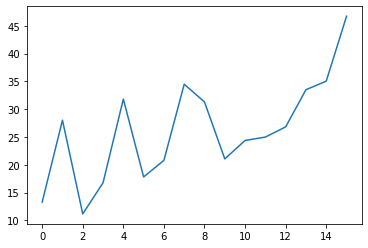

  0%|          | 17/3000000 [00:04<264:23:34,  3.15it/s]

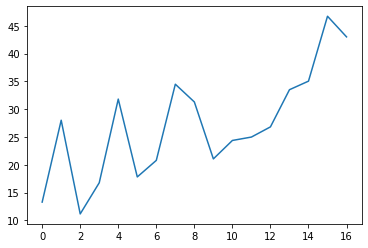

  0%|          | 18/3000000 [00:04<291:02:05,  2.86it/s]

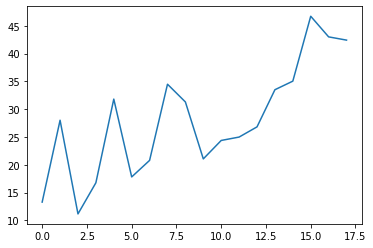

  0%|          | 19/3000000 [00:05<287:15:00,  2.90it/s]

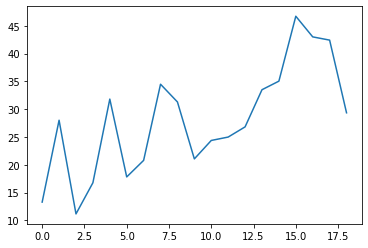

  0%|          | 20/3000000 [00:05<297:04:03,  2.81it/s]

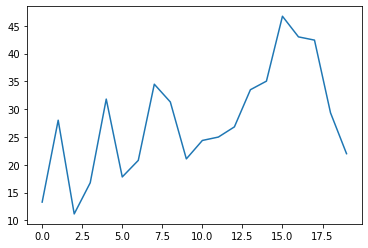

  0%|          | 21/3000000 [00:06<307:40:48,  2.71it/s]

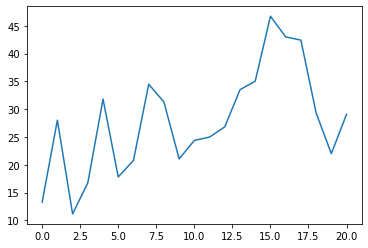

  0%|          | 22/3000000 [00:06<299:53:57,  2.78it/s]

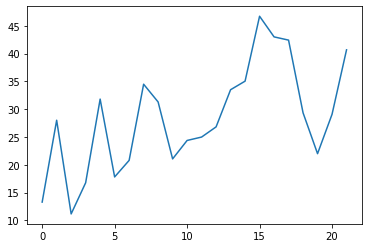

  0%|          | 23/3000000 [00:06<282:44:03,  2.95it/s]

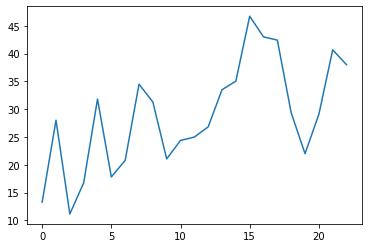

  0%|          | 24/3000000 [00:07<282:26:13,  2.95it/s]

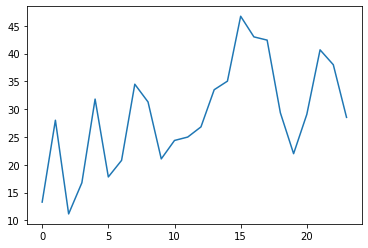

  0%|          | 25/3000000 [00:07<262:31:57,  3.17it/s]

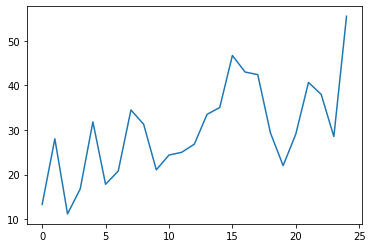

  0%|          | 26/3000000 [00:07<268:47:41,  3.10it/s]

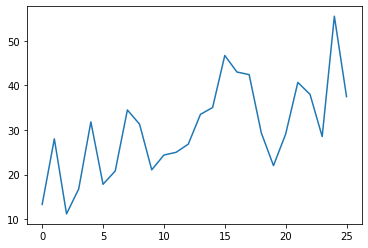

  0%|          | 27/3000000 [00:07<260:42:41,  3.20it/s]

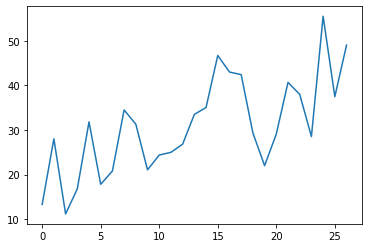

  0%|          | 28/3000000 [00:08<249:04:08,  3.35it/s]

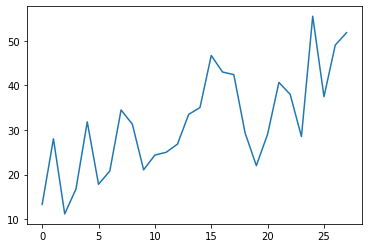

  0%|          | 29/3000000 [00:08<249:53:57,  3.33it/s]

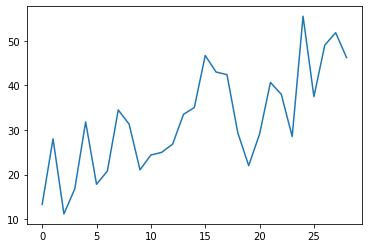

  0%|          | 30/3000000 [00:08<236:15:39,  3.53it/s]

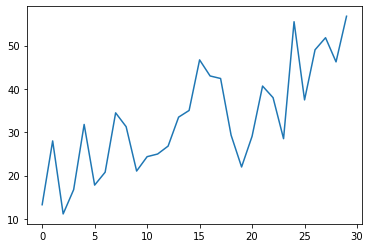

  0%|          | 31/3000000 [00:09<248:24:35,  3.35it/s]

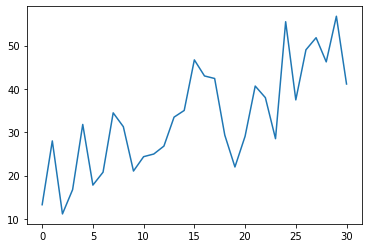

  0%|          | 32/3000000 [00:09<256:54:50,  3.24it/s]

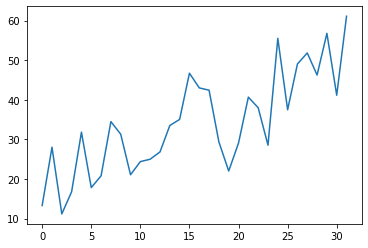

  0%|          | 33/3000000 [00:09<276:19:50,  3.02it/s]

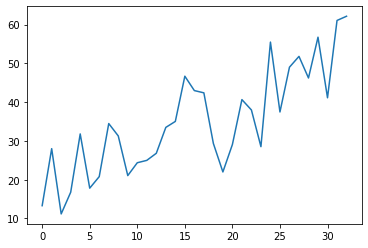

  0%|          | 34/3000000 [00:10<280:11:54,  2.97it/s]

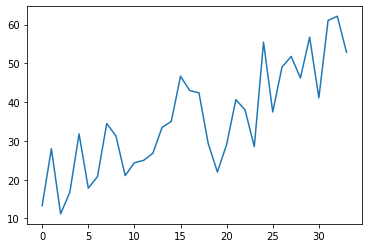

  0%|          | 35/3000000 [00:10<290:53:03,  2.86it/s]

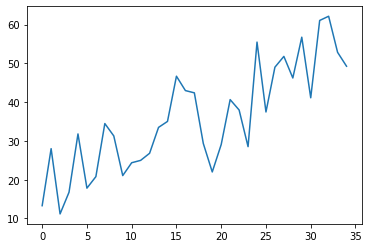

  0%|          | 36/3000000 [00:10<316:49:18,  2.63it/s]

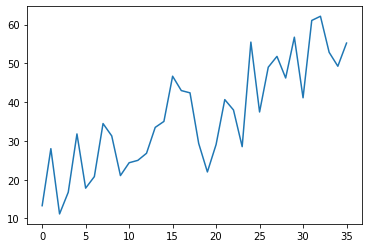

  0%|          | 37/3000000 [00:11<309:46:55,  2.69it/s]

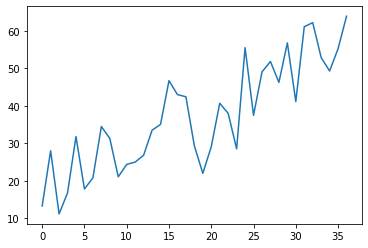

  0%|          | 38/3000000 [00:11<285:09:52,  2.92it/s]

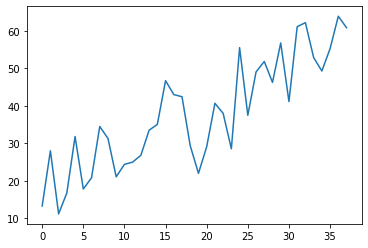

  0%|          | 39/3000000 [00:11<268:40:44,  3.10it/s]

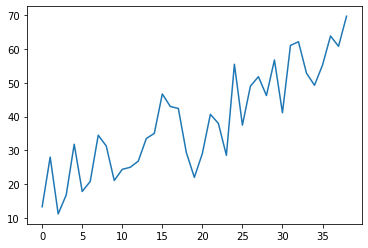

  0%|          | 40/3000000 [00:12<311:29:36,  2.68it/s]

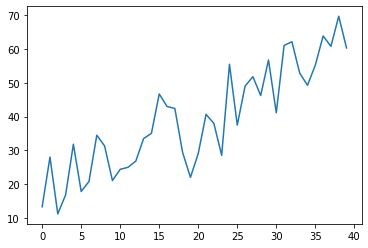

  0%|          | 41/3000000 [00:12<300:49:21,  2.77it/s]

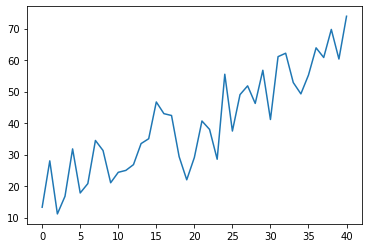

  0%|          | 42/3000000 [00:12<289:06:53,  2.88it/s]

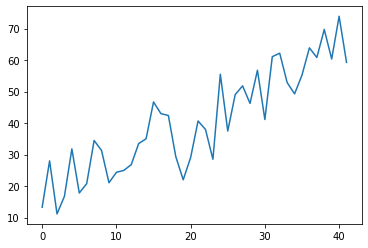

  0%|          | 43/3000000 [00:13<279:10:24,  2.98it/s]

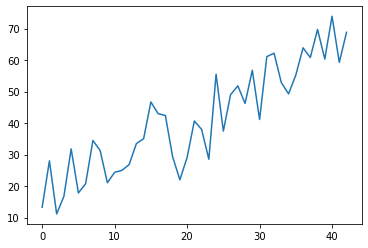

  0%|          | 44/3000000 [00:13<269:13:24,  3.10it/s]

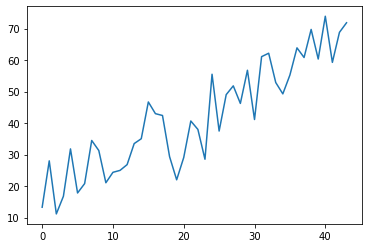

  0%|          | 45/3000000 [00:13<277:57:56,  3.00it/s]

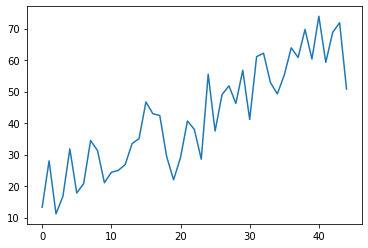

  0%|          | 46/3000000 [00:14<297:32:56,  2.80it/s]

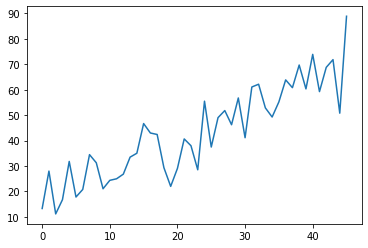

  0%|          | 47/3000000 [00:14<306:31:12,  2.72it/s]

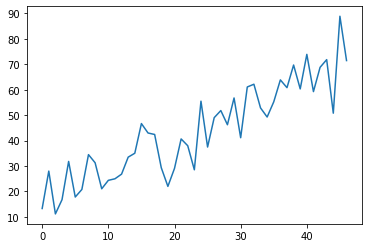

  0%|          | 48/3000000 [00:15<349:42:03,  2.38it/s]

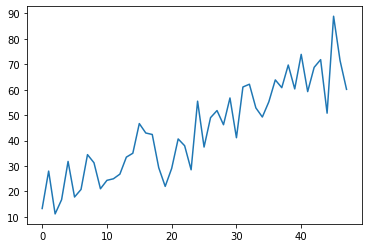

  0%|          | 49/3000000 [00:15<317:05:43,  2.63it/s]

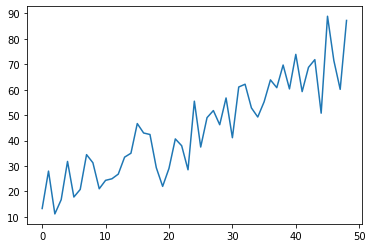

  0%|          | 50/3000000 [00:15<308:14:04,  2.70it/s]

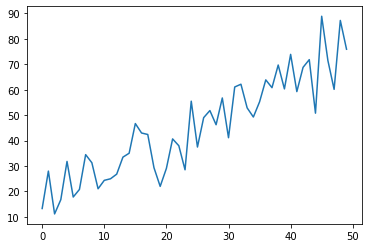

  0%|          | 51/3000000 [00:16<298:02:33,  2.80it/s]

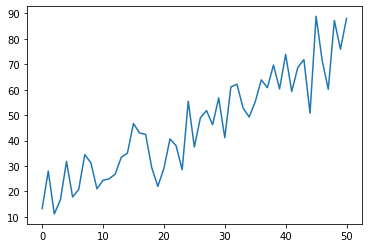

  0%|          | 52/3000000 [00:16<278:56:25,  2.99it/s]

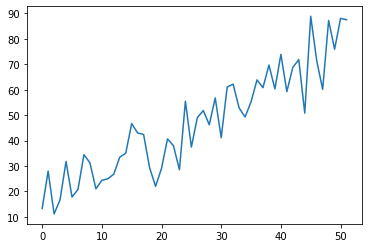

  0%|          | 53/3000000 [00:16<309:27:04,  2.69it/s]

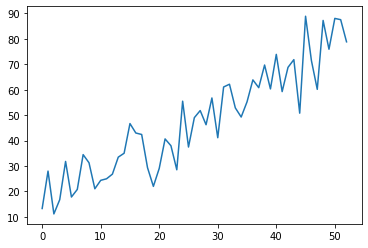

  0%|          | 54/3000000 [00:17<317:35:37,  2.62it/s]

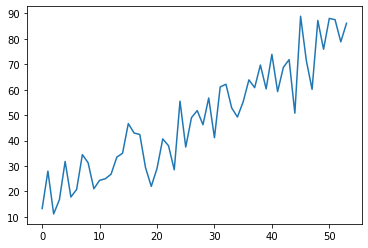

  0%|          | 55/3000000 [00:17<322:32:47,  2.58it/s]

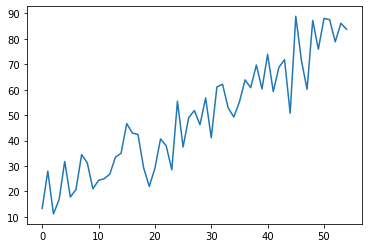

  0%|          | 56/3000000 [00:18<323:01:14,  2.58it/s]

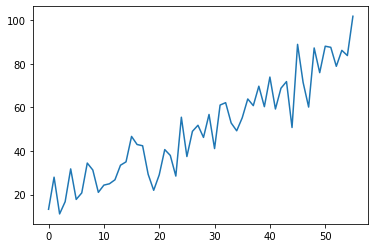

  0%|          | 57/3000000 [00:18<319:06:49,  2.61it/s]

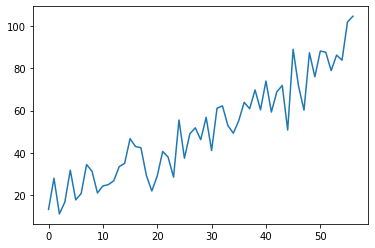

  0%|          | 58/3000000 [00:18<303:39:46,  2.74it/s]

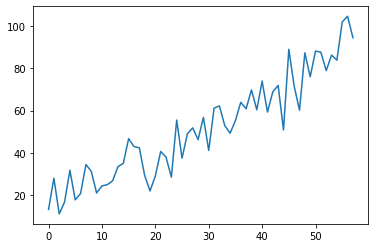

  0%|          | 59/3000000 [00:19<306:03:44,  2.72it/s]

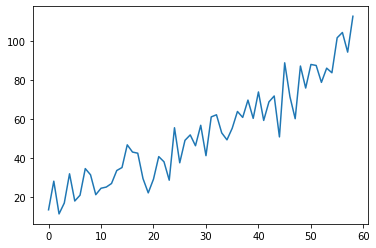

  0%|          | 60/3000000 [00:19<299:00:56,  2.79it/s]

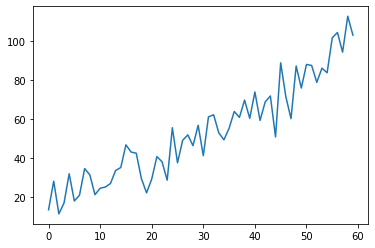

  0%|          | 61/3000000 [00:20<317:01:12,  2.63it/s]

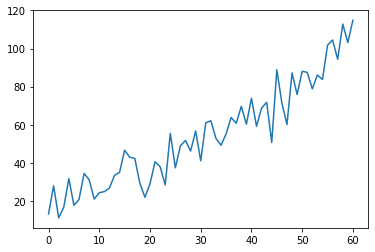

  0%|          | 62/3000000 [00:20<330:37:16,  2.52it/s]

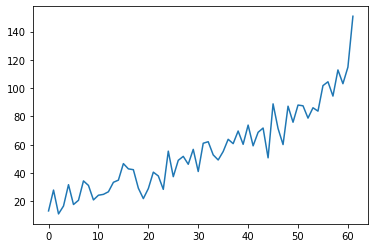

  0%|          | 63/3000000 [00:20<349:37:23,  2.38it/s]

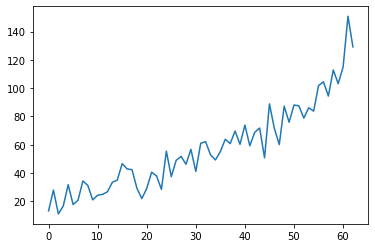

  0%|          | 64/3000000 [00:21<327:45:19,  2.54it/s]

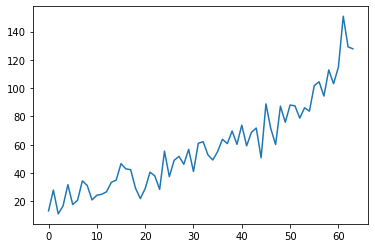

  0%|          | 65/3000000 [00:21<321:55:45,  2.59it/s]

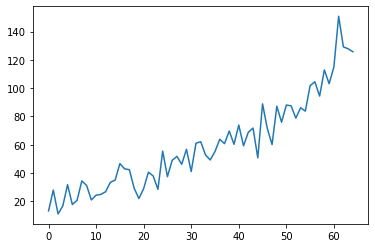

  0%|          | 66/3000000 [00:21<313:21:50,  2.66it/s]

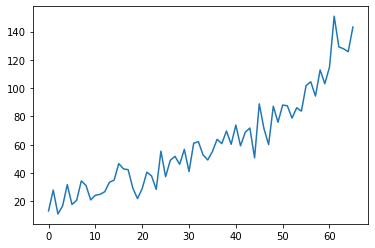

  0%|          | 67/3000000 [00:22<354:29:22,  2.35it/s]

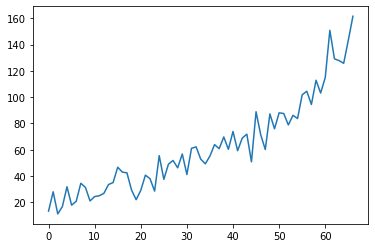

  0%|          | 68/3000000 [00:23<369:18:58,  2.26it/s]

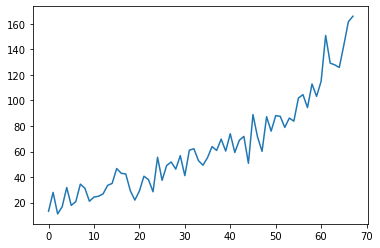

  0%|          | 69/3000000 [00:23<368:13:32,  2.26it/s]

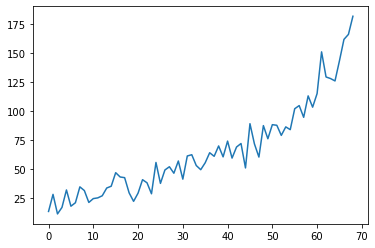

  0%|          | 70/3000000 [00:24<425:03:25,  1.96it/s]

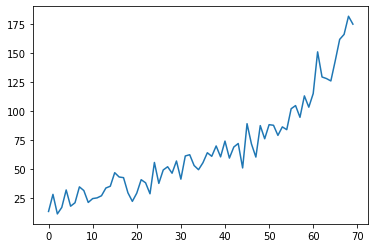

  0%|          | 71/3000000 [00:24<424:11:50,  1.96it/s]

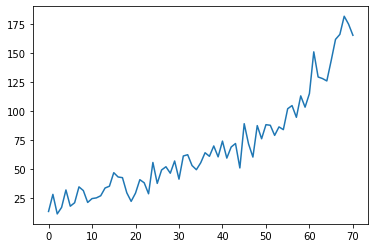

  0%|          | 72/3000000 [00:25<409:23:29,  2.04it/s]

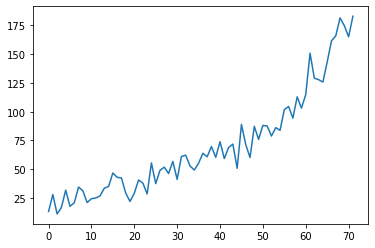

  0%|          | 73/3000000 [00:25<383:03:24,  2.18it/s]

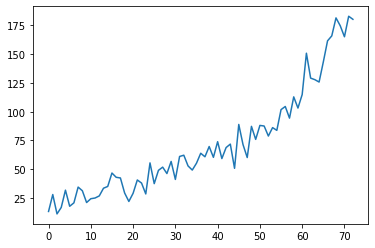

  0%|          | 74/3000000 [00:25<387:19:04,  2.15it/s]

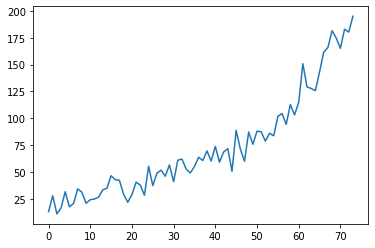

  0%|          | 75/3000000 [00:26<369:21:27,  2.26it/s]

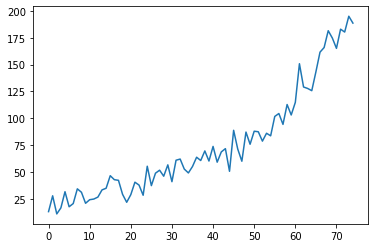

  0%|          | 76/3000000 [00:27<296:12:11,  2.81it/s]


KeyboardInterrupt: 

In [7]:
import gym
import gym_Boeing
# from tqdm import tqdm

GAME = 'boeing-danger-v0'
GAMMA = 0.99
EPOCHS = 1000
MAX_EPISODE_LENGTH = 3000
START_STEPS = 10000
RENDER_EVERY = 10

env = gym.make(GAME)
agent = DDPGAgent(env.observation_space.shape,env.action_space.shape[0],max(env.action_space.high))

state, reward, done, ep_rew, ep_len, ep_cnt = env.reset(), 0, False, [0.0], 0, 0
total_steps = MAX_EPISODE_LENGTH * EPOCHS

# Main loop: collect experience in env and update/log each epoch
for t in range(total_steps):
    #render from time for time because it floats my boat
    if ep_cnt % RENDER_EVERY == 0:
        env.render()
    #get action, at the beginning randomly later by neural net output+noise
    if t > START_STEPS:
        action = agent.get_action(state)
        action = np.squeeze(action)
    else:
        action = env.action_space.sample()

    # Step the env
    next_state, reward, done, _ = env.step(action)
    ep_rew[-1] += reward #keep adding to the last element till done
    ep_len += 1

    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    done = False if ep_len==MAX_EPISODE_LENGTH else done

    # Store experience to replay buffer
    agent.store(state,action,reward,next_state,done)

    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    state = next_state

    if done or (ep_len == MAX_EPISODE_LENGTH):
        ep_cnt += 1
        if True: #ep_cnt % RENDER_EVERY == 0:
            print(f"Episode: {len(ep_rew)-1}, Reward: {np.mean(ep_rew[-12:-2])}")
        ep_rew.append(0.0)
        """Perform all DDPG updates at the end of the trajectory.
        Train on a randomly sampled batch as often there were steps in this episode.
        I don't understand why it is updated that often, this is from the TD3 paper and 
        in accordance with the openai implementation.
        """
        for _ in range(ep_len):
            agent.train()

        state, reward, done, ep_ret, ep_len = env.reset(), 0, False, 0, 0

#make simple moving average over 5 episodes (smoothing) and plot
SMA_rewards = np.convolve(ep_rew, np.ones((5,))/5, mode='valid')
#Plot learning curve
plt.style.use('seaborn')
plt.plot(SMA_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()